In [1]:
#Import required libraries

import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras import optimizers

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Get Apple stock ptrice data from Tiingo
#Tiingo - https://api.tiingo.com/

#key = "Generate Key from Tiingo"
df = pdr.get_data_tiingo('GOOGL',api_key=key)

In [3]:
#Save dataset as csv
df.to_csv('GOOGL.csv')

In [4]:
#read the saved csv file
df = pd.read_csv('GOOGL.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOGL,2016-10-19 00:00:00+00:00,827.09,829.810,823.2050,824.52,1500142,827.09,829.810,823.2050,824.52,1500142,0.0,1.0
1,GOOGL,2016-10-20 00:00:00+00:00,821.63,828.465,820.5500,827.56,1393870,821.63,828.465,820.5500,827.56,1393870,0.0,1.0
2,GOOGL,2016-10-21 00:00:00+00:00,824.06,824.290,818.3100,820.00,1615814,824.06,824.290,818.3100,820.00,1615814,0.0,1.0
3,GOOGL,2016-10-24 00:00:00+00:00,835.74,837.940,829.0400,830.09,1447616,835.74,837.940,829.0400,830.09,1447616,0.0,1.0
4,GOOGL,2016-10-25 00:00:00+00:00,828.55,838.500,825.3005,838.50,1890712,828.55,838.500,825.3005,838.50,1890712,0.0,1.0


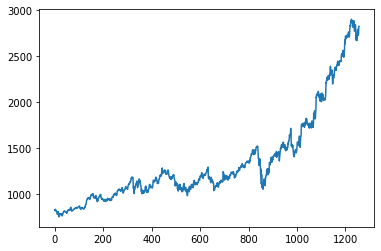

In [5]:
df = df.reset_index()['close']
plt.plot(df)

In [6]:
### LSTM are sensitive to the scale of the data. So we apply MinMax Scaler
scaler = MinMaxScaler()
df = scaler.fit_transform(np.array(df).reshape(-1,1))
df

array([[0.03434073],
       [0.03180248],
       [0.03293214],
       ...,
       [0.92902668],
       [0.96220986],
       [0.96422744]])

In [7]:
### Splitting data into Train and Test set
training_size = int(len(df)*0.7)
test_size =  len(df) - training_size

train_data = df[0:training_size,:]
test_data = df[training_size:len(df),:]

print("Train Data Size",training_size)
print("Test Data size",test_size)

Train Data Size 879
Test Data size 378


In [8]:
#Create Train and test data set

def create_dataset(dataset,time_step):
  dataX,dataY = [], []
  for i in range(len(dataset) - time_step - 1):
    a = dataset[i:(i + time_step),0]
    dataX.append(a)
    dataY.append(dataset[(i+time_step),0])
  return np.array(dataX),np.array(dataY)


#reshape into X = t,t+1,t+2,....,t+149 and y = t+150
time_step = 150
X_train, y_train = create_dataset(train_data,time_step)
X_test,  y_test  = create_dataset(test_data,time_step)


In [9]:
#reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test  = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [10]:
#Create Stacked LSTM Model

#return_sequence=True : If We want to have a sequence for the output, not just a single vector as we did with normal Neural Networks,
#so it’s necessary that we set the return_sequences to True. Concretely, let’s say we have an input with shape (num_seq, seq_len, num_feature).
#If we don’t set return_sequences=True, our output will have the shape (num_seq, num_feature), but if we do, we will obtain the output with shape (num_seq, seq_len, num_feature).

model = Sequential()

model.add(LSTM(50,return_sequences=True,input_shape=(150,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [12]:
optimizer = optimizers.Adam(learning_rate=0.01)

#Compile the Model
model.compile(loss='mean_squared_error',optimizer=optimizer)


In [13]:
#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_loss",patience=10,mode="auto",verbose=1)

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1,callbacks=[earlystop])

Epoch 1/100
12/12 [==============================] - 9s 389ms/step - loss: 0.0096 - val_loss: 0.1810
Epoch 2/100
12/12 [==============================] - 3s 275ms/step - loss: 0.0021 - val_loss: 0.0644
Epoch 3/100
12/12 [==============================] - 3s 272ms/step - loss: 6.3818e-04 - val_loss: 0.0519
Epoch 4/100
12/12 [==============================] - 3s 274ms/step - loss: 4.4688e-04 - val_loss: 0.0100
Epoch 5/100
12/12 [==============================] - 3s 272ms/step - loss: 3.8179e-04 - val_loss: 0.0193
Epoch 6/100
12/12 [==============================] - 3s 270ms/step - loss: 3.6201e-04 - val_loss: 0.0121
Epoch 7/100
12/12 [==============================] - 3s 272ms/step - loss: 3.3480e-04 - val_loss: 0.0117
Epoch 8/100
12/12 [==============================] - 3s 273ms/step - loss: 2.9703e-04 - val_loss: 0.0087
Epoch 9/100
12/12 [==============================] - 3s 272ms/step - loss: 2.6431e-04 - val_loss: 0.0130
Epoch 10/100
12/12 [==============================] - 3s 275ms/

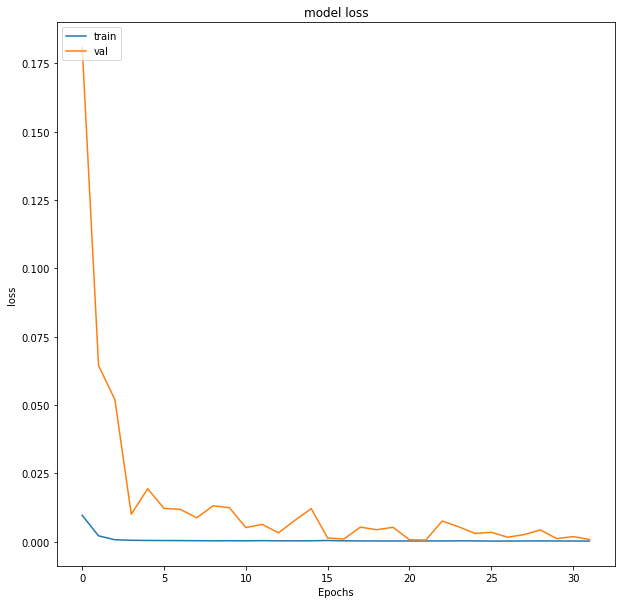

In [14]:
#Plot Model Loss
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel("Epochs")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
#Prediction
train_predict = model.predict(X_train)
test_predict =  model.predict(X_test)

In [16]:
#Transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict  = scaler.inverse_transform(test_predict)

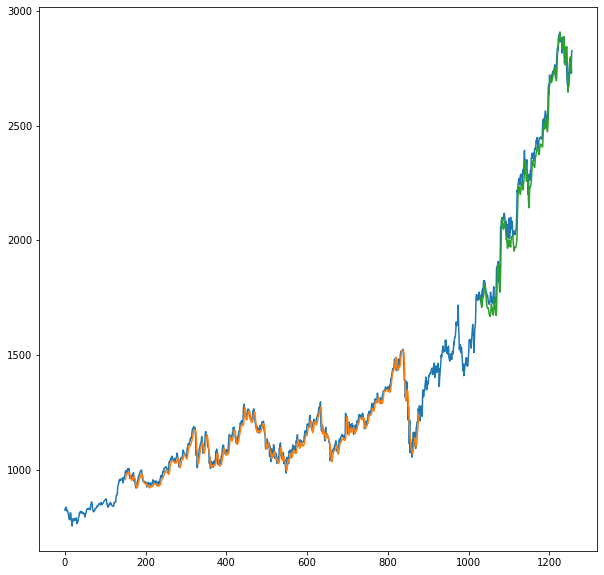

In [17]:
#Plotting

#Shift train prediction for plotting
look_back = 150
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict

plt.figure(figsize=(10, 10))
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [18]:
#Predict Stock price for the future 30 days
X_input = test_data[228:,:].reshape(1,-1)
X_input.shape

(1, 150)

In [19]:
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [20]:
lst_output = []
n_steps = 150
i = 0

while(i <30):
  if(len(temp_input)>150):
    x_input = np.array(temp_input[i:])
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input)
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat[0].tolist())
    i = i + 1
  else:
    x_input = np.array(temp_input[i:])
    x_input =  x_input.reshape((1, n_steps, 1))
    yhat = model.predict(x_input)
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat[0].tolist())
    i = i + 1

In [21]:
predict_df =df.flatten().tolist()
predict_df.extend(lst_output)

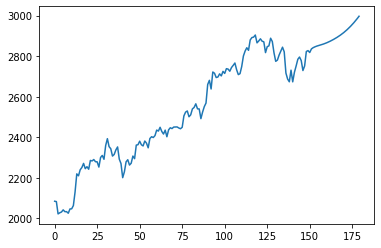

In [22]:
plt.plot(scaler.inverse_transform(np.array(temp_input).reshape(-1,1)))